<a href="https://colab.research.google.com/github/1kaiser/3D-printed-mirror-array/blob/main/%F0%9F%AA%9Emirror_array.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# test section



testing sin x cos x

In [ ]:

def sin5q(x):
        A = 6.28230858
        B = -41.1693687
        C = 74.4388885
        x2 = x * x
        return x * (A + x2 * (B + x2 * C))
    
def sin(x):
        pi2 = 1 / (2 * 3.1415926535)
        x_2 = 0.25 - x * pi2;
        z = 0.25 - abs(x_2 - round(x_2))
        print(sin5q(z))
        return sin5q(z)
    
def cos(x):
        pi2 = 1 / (2 * 3.1415926535)
        x_2 = x * pi2
        z = 0.25 - abs(x_2 - round(x_2))
        print(sin5q(z))
        return sin5q(z)
  
print("hello world")

   

trying to plot >>>>

In [ ]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

pi2 = 1 / (2 * 3.1415926535)
%time cos(jnp.linspace(0,pi2,50))
%time sin(jnp.linspace(0,pi2,50))
a,b=jnp.sin(jnp.linspace(0,pi2*400,50)), sin(jnp.linspace(0,pi2,50))
c,d=jnp.cos(jnp.linspace(0,pi2*400,50)), sin(jnp.linspace(0,pi2,50))
e,f=jnp.cos(jnp.linspace(0,pi2*400,50)), cos(jnp.linspace(0,pi2,50))+sin(jnp.linspace(0,pi2,50))
plt.scatter(a,b);

trying with jax

In [ ]:
import jax.numpy as jnp
%time jnp.sin(3.14159*.5)
%time sin(3.14159*.5)

In [ ]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

xs = random.normal(0,shape=(100,))
noise = random.normal(scale=0.1, shape=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(jnp.sin(ys), sin(ys));

original c++ code

In [ ]:
%%writefile filename.cpp

#include<stdio.h>

int main(void) {
    // Polynomial approximation of degree 5 for
    // sin(x * 2 * pi) in the range [-1/4, 1/4]
    static float sin5q(float x) {
        // A * x + B * x^3 + C * x^5
        // Exact at x = 0, 1/12, 1/6, 1/4, and their negatives,
        // which correspond to x * 2 * pi = 0, pi/6, pi/3, pi/2
        constexpr float A = 6.28230858 f;
        constexpr float B = -41.1693687 f;
        constexpr float C = 74.4388885 f;
        float x2 = x * x;
        return x * (A + x2 * (B + x2 * C));
    }
    float sin(float x) {
        constexpr float pi2 = 1 / (2 * 3.1415926535 f);
        // Range reduction and mirroring
        float x_2 = 0.25 f - x * pi2;
        float z = 0.25 f - abs(x_2 - round(x_2));
        return sin5q(z);
    }
    float cos(float x) {
        constexpr float pi2 = 1 / (2 * 3.1415926535 f);
        // Range reduction and mirroring
        float x_2 = x * pi2;
        float z = 0.25 f - abs(x_2 - round(x_2));
        return sin5q(z);
    }
    printf("hello world");
    return 0;
}

In [ ]:
%%shell
g++ filename.cpp -o output
./output

# main section

In [ ]:
import jax.numpy as jnp
from numpy import sin, cos, tan, pi
import matplotlib.pyplot as plt

import stl  # pip install numpy-stl

import hexy as hx  #pip install hexy

# vPython is only required for visualization code.
# If you just want to generate the models, you can disable this.
import vpython as vis  # pip install vpython
from vpython import vec

### Notes:

- All spatial dimensions in this notebook are in millimeters unless otherwise specified
- The mirror array is assumed to have its base on the $(x,y)$ plane, a distance $y$ from the ground, and is facing the sun which is in the $+z$ direction.

# Computing the mirror angles

The basic idea here is that we have an array of mirrors forming a hexagonal grid. Each mirror is located with its centroid at some point in space, and we want for it to reflect a ray of sunlight to a pixel at some location on the ground (or any other focal plane). Since we know where each mirror is, where each corresponding target is, and where the sun is, we can solve for how each mirror needs to be oriented in 3D space in order to reflect the sunlight onto its corresponding target.

Consider just a single mirror and a single target pixel. The center of the mirror has $(x, y, z)$ coordinates located at some vector mirror_pos, and the center of the target pixel is at target_pos. Let's define vectors $\vec{u}, \vec{v}$ such that $\vec u =$mirror_pos - target_pos is the vector pointing from the target to the mirror center, and $\vec v = \left(\sin \phi, \cos \phi \sin \theta, \cos \phi \cos \theta\right)$ is the vector pointing in the direction of the sun (a point source placed at infinity). Here we're assuming the sun is at an inclination of $\theta$ from the horizon and that the azimuthal angle relative to the mirror is $latex \phi$. 

Since the reflected angles are the same as the incident angles for a mirror, the normal vector $\hat n$ of the mirror just needs to bisect these two vectors $\vec u$ and $\vec v$, so we have that $\hat n = \frac{\vec v}{|| \vec v ||} - \frac{\vec u}{|| \vec u ||}$:


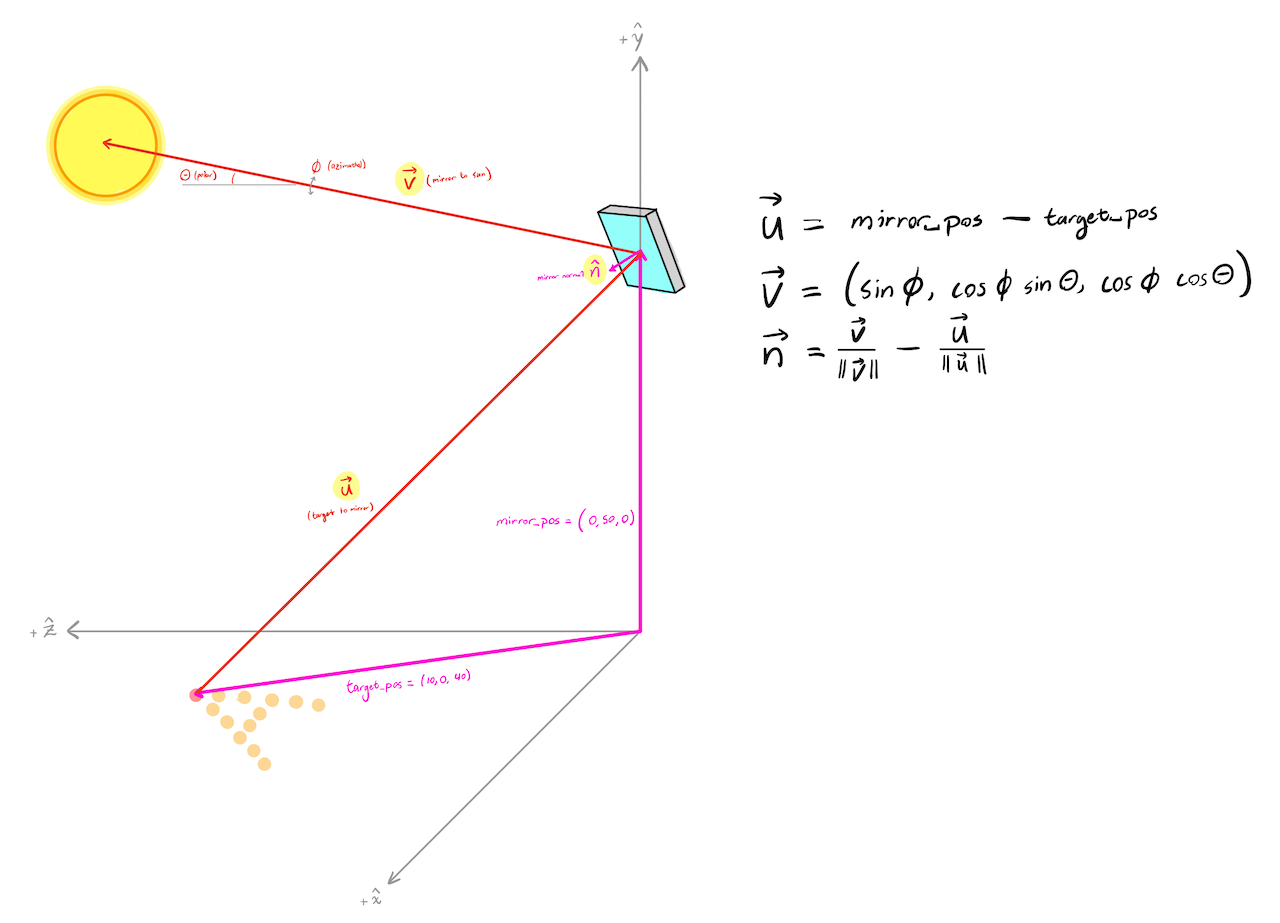

In [ ]:
def compute_mirror_normal(mirror_pos, target_pos, sun_azimuth_θ, sun_angle_ϕ = 0.0):
    """Returns a unit normal vector for the mirror to shine light on a target position"""
    
    v_target_mirror = mirror_pos - target_pos

    θ = sun_azimuth_θ
    ϕ = sun_angle_ϕ
    v_mirror_sun = np.array([sin(ϕ), cos(ϕ) * sin(θ), cos(ϕ) * cos(θ)])

    mirror_normal = normalize(v_mirror_sun) - normalize(v_target_mirror)
    return normalize(mirror_normal)
    

# Generating a 3D model of a hexagonal prism

A 3D model is just a list of vertices and faces. The vertices are the corners of the polygon (a list of 3D coordinates) and the faces are a list of triangular facets, where each face is specified by tuple containing the indices of three vertices. So to generate the 3D model of the hexagonal prism, I just needed to compute the coordinates for the corners of the prism and the define triangular facets that form the outer faces of the prism.

The 3D printed plastic frame of the mirror array is made up of a grid of hexagonal prisms. Each hexagonal prism has its base on the $latex (x,y)$ plane and has a position $latex \vec p$ specified by the location of the centroid of the top face (coordinate 7 in the left image), which is normal to the vector $latex \hat n$. To compute the coordinates for the top corners, I computed the intersection of the plane defined by $latex \vec p, \vec n$ and the vector pointing vertically from each corner of the base (right image). I then just used a hard-coded list of vertex indices to specify the faces (so, for example, one face is (0,5,6), while another is (5,12,13) when referring to the left image).


Another thing I included in this function was the ability to add a mirror aligner structure to the prism. This mirror aligner is a small protrusion on two sides of the hex prism which fits on a corner of the hexagonal mirrors, which makes it much less tedious to glue hundreds of mirrors to the final structure (right image below). A subtle detail here is that the coordinates of the mirror aligner are not collinear with the coordinates of the top corners of the hex prism: the mirror aligner always needs to make a $120^\circ$ angle, but if the hex prism has a top surface with a steep slope, the corner angles get distorted. So to compute the coordinates of the mirror aligner, I computed the projection of the x axis onto the plane of the the top of the prism as $\hat{x}' = \hat y \times \hat n$. Then I rotated this vector about the normal vector $\hat n$ by increments of $2 \pi / 6$ to get the corners of the aligner.



In [ ]:
def intersection_line_plane(p0, p1, p_co, p_no, epsilon=1e-9):
    """
    Copied from https://stackoverflow.com/questions/5666222/3d-line-plane-intersection
    
    p0, p1: Define the line.
    p_co, p_no: define the plane:
        p_co Is a point on the plane (plane coordinate).
        p_no Is a normal vector defining the plane direction;
             (does not need to be normalized).

    Return a Vector or None (when the intersection can't be found).
    """
    
    def add_v3v3(v0, v1):
        return (v0[0] + v1[0], v0[1] + v1[1], v0[2] + v1[2])

    def sub_v3v3(v0, v1):
        return (v0[0] - v1[0], v0[1] - v1[1], v0[2] - v1[2])

    def dot_v3v3(v0, v1):
        return ((v0[0] * v1[0]) + (v0[1] * v1[1]) + (v0[2] * v1[2]))

    def len_squared_v3(v0):
        return dot_v3v3(v0, v0)

    def mul_v3_fl(v0, f):
        return (v0[0] * f, v0[1] * f, v0[2] * f)

    u = sub_v3v3(p1, p0)
    dot = dot_v3v3(p_no, u)

    if abs(dot) > epsilon:
        # The factor of the point between p0 -> p1 (0 - 1)
        # if 'fac' is between (0 - 1) the point intersects with the segment.
        # Otherwise:
        #  < 0.0: behind p0.
        #  > 1.0: infront of p1.
        w = sub_v3v3(p0, p_co)
        fac = -dot_v3v3(p_no, w) / dot
        u = mul_v3_fl(u, fac)
        return add_v3v3(p0, u)
    else:
        # The segment is parallel to plane.
        return None

In [ ]:
def rad_from_deg(deg):
    return deg * np.pi / 180

def normalize(v):
    """Normalizes a vector, returning v / ||v||"""
    return v / np.linalg.norm(v)


def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = cos(theta / 2.0)
    b, c, d = -axis * sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

In [ ]:
def create_hex_prism(center_pos_vec, normal_vec, triangle_radius, add_mirror_aligners=False, aligner_inner_radius=None, aligner_thickness=0.5):
    """
    Creates a 3D model of a hexagonal prism which can hold a mirror. 
    Assumptions:
    - Base plane is at z=0
    - Triangle radius is center-to-corner and points in +/- x direction
    
    
    Args:
        center_pos_vec: the centroid of the top of the hexagonal prism
        normal_vec: the normal vector of the top face of the prism
        triangle_radius: the distance from the center of the bottom base of the prism to one of the bottom corners
        add_mirror_aligners: if True, will add protruding structures that help with aligning mirrors when gluing them on
        aligner_inner_radius: the distance from the centroid of the top face to the inner edge of the aligner (the radius of your mirror)
        aligner_thickness: the thickness of the aligner
        
    Returns:
        A stl mesh for the hexagonal prism
    """

    # Create base vertices
    base_center = [center_pos_vec[0], center_pos_vec[1], 0.0]
    base_corners = [
        base_center + (triangle_radius * (rotation_matrix([0,0,1], θ) @ np.array([1,0,0])))
        for θ in 2*pi/6 * np.arange(6)
    ]
    base_vertices = np.array([base_center, *base_corners])

    # Create top vertices 
    top_center = np.copy(center_pos_vec)
    # top_corners = [[v[0], v[1], 1000.0] for v in base_corners]
    top_corners = np.array([intersection_line_plane(v, [v[0], v[1], 1000.0], center_pos_vec, normal_vec) for v in base_corners])
    top_vertices = np.array([top_center, *top_corners])

    # Create the mesh vertices and faces
    vertices = np.array([*base_vertices, *top_vertices])
    bottom_faces = [
        [0,1,2],
        [0,2,3],
        [0,3,4],
        [0,4,5],
        [0,5,6],
        [0,6,1]
    ]
    top_faces = [
        [7,8,9],
        [7,9,10],
        [7,10,11],
        [7,11,12],
        [7,12,13],
        [7,13,8]
    ]
    side_faces = [
        [1,9,2],  [1,8,9],
        [2,10,3], [2,9,10],
        [3,11,4], [3,10,11],
        [4,12,5], [4,11,12],
        [5,13,6], [5,12,13],
        [6,1,8],  [6,13,8]
    ]
    faces = np.array([*bottom_faces, *top_faces, *side_faces])

    # Create the mesh
    hex_prism = stl.mesh.Mesh(np.zeros(faces.shape[0], dtype=stl.mesh.Mesh.dtype))
    for i, face in enumerate(faces):
        for j in range(3):
            hex_prism.vectors[i][j] = vertices[face[j],:]
            
    # Add alignment ridges to place mirrors into
    if add_mirror_aligners:
        if aligner_inner_radius is None:
            raise ValueError("Need to specify alignemnt radius!")
            
        aligner_outer_radius = aligner_inner_radius + aligner_thickness
        if aligner_outer_radius > triangle_radius:
            raise ValueError("Aligner thickness plus width too large!")
            
        # Create base vertices
        aligner_center = np.copy(center_pos_vec)
        x_plus_on_face = normalize(np.cross(np.array([0,1,0]), normal_vec))
        aligner_inner_corners = [
            aligner_center + aligner_inner_radius * (rotation_matrix(normal_vec, θ) @ x_plus_on_face)
            for θ in 2*pi/6 * np.array([-1,0,1])
        ]
        aligner_outer_corners = [
            aligner_center + aligner_outer_radius * (rotation_matrix(normal_vec, θ) @ x_plus_on_face)
            for θ in 2*pi/6 * np.array([-1,0,1])
        ]
        aligner_bottom_vertices = np.array([*aligner_inner_corners, *aligner_outer_corners])
        
        unit_normal_vec = normal_vec / np.linalg.norm(normal_vec)
        aligner_top_vertices = aligner_bottom_vertices + (aligner_thickness * unit_normal_vec)
        
        aligner_vertices = np.array([*aligner_bottom_vertices, *aligner_top_vertices])
        aligner_bottom_faces = [
            [0,1,3],
            [3,1,4],
            [1,2,5],
            [1,5,4]
        ]
        aligner_top_faces = list(np.array(aligner_bottom_faces) + 6)
        aligner_side_faces = [
            [8,2,11],
            [2,11,5],
            [8,2,7],
            [2,1,7],
            [1,7,0],
            [7,6,0],
            [0,6,9],
            [0,3,9],
            [3,9,10],
            [3,4,10],
            [4,10,5],
            [10,5,11]
        ]
        aligner_faces = np.array([*aligner_bottom_faces, *aligner_top_faces, *aligner_side_faces])
        # Create the mesh
        aligner_mesh = stl.mesh.Mesh(np.zeros(aligner_faces.shape[0], dtype=stl.mesh.Mesh.dtype))
        for i, face in enumerate(aligner_faces):
            for j in range(3):
                aligner_mesh.vectors[i][j] = aligner_vertices[face[j],:]
       
        # Fuse with hex prism
        hex_prism = fuse_models([hex_prism, aligner_mesh])
            
    return hex_prism

def fuse_models(models):
    """Fuses together a list of 3D models by concatenating their vertices and faces"""
    all_data = np.concatenate([model.data.copy() for model in models])
    return stl.mesh.Mesh(all_data)

# Generating a hexagonal grid of prisms

In [ ]:
def get_hex_grid_centers(num_hexes_radius, mini_hex_radius):
    """Creates a large hexagonal grid of mini-hexagons. Returns the 2D xy centerpoint for each hexagon.
    Args:
        num_hexes_radius: the radius of the hexagonal grid. A single point is R=1, seven points is R=2, 19 points is R=3, etc.
        mini_hex_radius: the radius of one of the hexagons in the grid (the radius of the hexagonal prisms)
    """
    coords = hx.get_spiral(np.array((0, 0, 0)), 1, num_hexes_radius) # The center is in hexagonal, "fake", xyz cubic coordinates
    x, y = hx.cube_to_pixel(coords, mini_hex_radius).T
    centers = np.array([y, x]).T
    return centers

def mirror_pos_from_xy_base(center, center_height=20, distance_scaling=0.0, x_offset=0.0, y_offset=0.0):
    """Converts xy coordinates of a hexagonal base to the xyz coordinates of mirror centers
    Args:
        center: the center xy coordinate of the base
        center_height: the height of the centermost prism
        distance_scaling: prisms a radius r from the center will have their heigh adjusted by distance_scaling * r amount
        x_offset: shift all prisms by this amount on x axis
        y_offset: shift all prisms by this amount on y axis
    """
    distance_from_center = np.linalg.norm(center)
    height = center_height + distance_scaling * distance_from_center
    center_vec = np.array([center[0] + x_offset, center[1] + y_offset, height])
    return center_vec

def make_hex_prism_grid(mirror_positions, mirror_normals, mini_hex_radius, add_mirror_aligners=True, x_offset=0.0, y_offset=0.0, verbose=True, no_fuse_models=False):
    """Makes a grid of hexagonal prisms given a list of mirror positions and corresponding normal vectors
    Args:
        mirror_positions: xyz coordinates of the mirror centroids
        mirror_normals: normal vector for each mirror
        mini_hex_radius: radius of each of the hexagonal prisms in the grid
        no_fuse_models: if True, a list of hexagonal prisms meshes will be returned instead of a single fused model (useful for partitioning)
    """
    all_prisms = []
    for mirror_pos, mirror_normal in zip(mirror_positions, mirror_normals):
        hex_prism = create_hex_prism(mirror_pos, mirror_normal, mini_hex_radius, add_mirror_aligners=add_mirror_aligners, aligner_inner_radius=mini_hex_radius-1.0, aligner_thickness=1.0)
        all_prisms.append(hex_prism)
    if verbose:
        print("Created model with {} hex prisms".format(len(all_prisms)))
    if no_fuse_models:
        return all_prisms
    else:
        return fuse_models(all_prisms)

In [ ]:
coords = hx.get_spiral(np.array((0, 0, 0)), 1, 3)
x, y = hx.cube_to_pixel(coords, 1).T
points = np.array([y, x]).T

In [ ]:
def plot_hex_points(points, num=len(points)):
    # Test visualize
    plt.scatter(points.T[0][0:num], points.T[1][0:num])
    plt.axis("equal")
    plt.show()
    
plot_hex_points(points)

# Test: aligning the mirrors to a single point in 3D space

This will create a $R=2$ hexagonal grid with all mirrors aligned to a common focal point. You can open the output model in Cura (or whatever slicing program you use) and re-run this function to see how the mirrors will change when you move the point around.

In [ ]:
target_pos = np.array([0, 0, 40]) # the common focal point

θ = np.deg2rad(0) # This is the angle with respect to the XY plane, normal to the overall structure
ϕ = np.deg2rad(0)

grid_hex_radius = 2
mini_hex_radius = 10

hex_centers = get_hex_grid_centers(grid_hex_radius, mini_hex_radius)
mirror_positions = [mirror_pos_from_xy_base(center, center_height=20, distance_scaling=.2) for center in hex_centers]
mirror_normals = [compute_mirror_normal(mirror_pos, target_pos, θ, ϕ) for mirror_pos in mirror_positions]

hex_prism_grid = make_hex_prism_grid(mirror_positions, mirror_normals, mini_hex_radius * .9)


base_positions = [mirror_pos_from_xy_base(center, center_height=5, distance_scaling=0) for center in hex_centers]
base_normals = np.tile(np.array([0,0,1]), (len(hex_centers),1))
hex_prism_bases = make_hex_prism_grid(base_positions, base_normals, mini_hex_radius * 1.1, add_mirror_aligners=False)

hex_prism_grid_combined = fuse_models([hex_prism_grid, hex_prism_bases])

hex_prism_grid_combined.save("stl/hex_prism_grid_single_focus.stl")

# Formatting coordinates for an image 

This section generates and formats the set of 2D coordinates that define the image you would like to project, and can transform them to 3D coordinates on the focal plane.

## Notes:

- I extracted the coordinates that I used to form the image by using the coordinate picker tool in Mathematica. However, you can also use an online image coordinate picker tool like this: [https://www.mobilefish.com/services/record_mouse_coordinates/record_mouse_coordinates.php](https://www.mobilefish.com/services/record_mouse_coordinates/record_mouse_coordinates.php)
- You will need to format the coordinates as a 2D Python list
- All coordinates are assumed to be in millimeters, you will need to rescale them to the desired size of the projected image
- IMPORTANT: you need to horizontally mirror the image you would like to project!

In [ ]:
# Pasted from mathematica output
coords = [[749.67, 438.1], [1204.75, 469.56], [546.35, 438.88], [1275.28, 832.91], [1017.78, 833.74], [647.6295776367188, 799.1300964355469], [724.099609375, 799.9089050292969], [266.5836181640625, 817.9267272949219], [472.28, 825.59], [749.72, 380.21], [545.87, 382.16], [452.72, 854.7], [286.96, 853.25], [715., 402.43], [268.17, 763.19], [566.45, 435.89], [728.47, 434.11], [1216.48, 375.58], [1187.9737548828125, 256.1741943359375], [1195.5775146484375, 256.1741943359375], [1192.04, 263.91], [1190.316650390625, 319.66131591796875], [1190.37, 339.86], [1200.08, 360.98], [1232.17, 392.32], [1242.01, 414.51], [1240.2, 442.8], [1226.76, 460.95], [1179.57, 470.69], [1158.2, 461.2], [1144.78, 446.96], [1138.196044921875, 426.24267578125], [897.4918823242188, 418.1148681640625], [926.57, 467.27], [960.62, 466.59], [993.49, 467.39], [927.3, 366.3], [956.21, 365.58], [993.6444091796875, 257.5711669921875], [958.5223388671875, 257.8609619140625], [924.378173828125, 258.04620361328125], [898.84, 282.62], [898.1, 310.38], [896.8499755859375, 340.74298095703125], [897.62, 392.57], [897.430908203125, 443.7537841796875], [898.8089599609375, 366.19598388671875], [1019.248291015625, 465.7032470703125], [988.32, 367.04], [1022.5699462890625, 257.55078125], [898.09, 257.23], [897.6317138671875, 467.7864990234375], [545.9, 412.09], [578.06, 406.69], [471.71, 759.91], [749.8, 410.35], [749.28, 348.51], [697.87, 364.76], [595.89, 369.18], [545.29, 351.59], [544.24755859375, 320.94464111328125], [615.7874755859375, 323.77764892578125], [677.2498168945312, 322.1021728515625], [749.7682495117188, 321.30474853515625], [750.0340576171875, 286.13226318359375], [661.3663940429688, 288.0025634765625], [633.14208984375, 288.0025634765625], [544.21484375, 286.75433349609375], [751.0889892578125, 255.06298828125], [745.34, 465.11], [647.705078125, 257.4637451171875], [548.85, 467.3], [545.132568359375, 254.5081787109375], [1484.33, 806.92], [1433.8072509765625, 805.7794647216797], [1459.27, 692.7], [1458.76, 719.32], [1457.575439453125, 745.1332092285156], [1397.06, 866.63], [1408.35, 846.25], [1421.2, 825.46], [1446.67, 784.15], [1469.96, 785.14], [1497.03, 828.66], [1508.74, 848.17], [1520.617919921875, 869.9008636474609], [1458.5758056640625, 766.6499633789062], [1530.668212890625, 884.5923004150391], [1384.2706298828125, 883.6441497802734], [1458.09423828125, 671.2614135742188], [1185.76, 882.84], [1223.1552734375, 882.6755676269531], [1251.27, 875.17], [1270.83, 857.79], [1268.17431640625, 805.2270812988281], [1245.04, 787.51], [1181.78, 781.8], [1211.3526611328125, 781.2495880126953], [1226.75, 754.47], [1244.0364990234375, 725.6549987792969], [1261.5723876953125, 697.1242370605469], [1277.6258544921875, 671.0181884765625], [1155.409912109375, 672.613037109375], [1155.4261474609375, 704.9848327636719], [1155.4664306640625, 730.7848815917969], [1155.3052978515625, 756.4649353027344], [1155.66796875, 781.4039306640625], [1155.81, 807.5], [1154.74, 834.85], [1154.44, 860.99], [1154.1702880859375, 883.5802764892578], [897.8416748046875, 804.0701904296875], [897.5758666992188, 833.1923522949219], [897.0039672851562, 861.1928863525391], [922.34, 882.96], [955.9832153320312, 883.3663787841797], [985.98, 879.14], [1010.79, 862.27], [1012.2882080078125, 805.221923828125], [987.794921875, 786.5226898193359], [925.7581787109375, 781.9527893066406], [897.406982421875, 756.2396545410156], [968.6502685546875, 757.0301513671875], [986.75, 729.44], [897.3654174804688, 732.0417785644531], [897.139892578125, 698.6778564453125], [1003.6195068359375, 698.6194152832031], [955.4535522460938, 782.1603088378906], [898.4556884765625, 781.937255859375], [897.9386596679688, 882.872314453125], [1021.3914794921875, 670.7004699707031], [898.5322875976562, 671.0590209960938], [651.59, 734.93], [717.95, 734.58], [762.74, 703.86], [605.9717407226562, 703.7068481445312], [634.17, 767.06], [735.34, 769.67], [712.33, 830.17], [660.43, 828.6], [671.5, 851.59], [702.06005859375, 853.2278900146484], [749.8562622070312, 736.0979309082031], [621.53, 736.07], [685.41, 735.23], [685.58, 879.34], [776.983154296875, 672.78271484375], [593.150146484375, 671.5205993652344], [268.43, 700.08], [349.78631591796875, 709.9300231933594], [389.09, 710.53], [471.39, 705.05], [471.59, 731.2], [402.43, 746.08], [334.43, 747.92], [267.55, 731.3], [266.57, 851.98], [301.76, 822.9], [439.2, 827.33], [470.74, 853.1], [471.35, 791.46], [422.74, 789.53], [316.13, 789.57], [267.87, 791.82], [471.3092041015625, 673.2996826171875], [469.02, 882.34], [369.4679870605469, 675.087646484375], [270.44, 881.96], [267.99627685546875, 670.501220703125]]
coords = np.array(coords)

coords -= np.array([900,550])
coords *= 120 / 1200 # width of about 48 inches
coords *= 10 # cm to mm

coords *= np.array([-1,1]) # IMPORTANT: need to mirror the array!

print(coords.shape)

plt.figure(figsize=(12,8))
plt.scatter(coords.T[0], coords.T[1])
plt.show()

In [ ]:
coords_heart = [[599.4664306640625, 119.61083984375], [683.27, 190.94], [512.4031982421875, 192.084716796875], [1101.1800537109375, 620.8414306640625], [1133.19, 796.36], [66., 790.18], [105.59696960449219, 601.76708984375], [201.69, 473.63], [1006.43, 481.81], [1090.34, 965.27], [101.91, 954.78], [536.77880859375, 1007.7824401855469], [656.955078125, 1004.5348815917969], [724., 1055.37], [482.96, 1051.51], [407.31, 1082.43], [791.62, 1080.77], [969.3441162109375, 1067.0575714111328], [218.079345703125, 1061.4600219726562], [154.13, 1019.47], [1030.3, 1030.55], [1124.528564453125, 704.10302734375], [76.73, 689.26], [416.39, 281.09], [770.11, 268.22], [336.1, 349.31], [862.73, 349.14], [936.64, 413.03], [267.752685546875, 407.59344482421875], [146.53, 537.92], [1061.13, 546.2], [1127.97, 874.39], [71.11, 869.47], [307.07, 1087.15], [880.68, 1088.85], [600.4229736328125, 931.498046875], [599.6448974609375, 112.80242919921875]]
coords_heart = np.array(coords_heart)

coords_heart -= np.array([600,600])
coords_heart *= 15 / 500
coords_heart *= 10 # cm to mm

print(coords_heart.shape)

plt.figure(figsize=(12,8))
plt.scatter(coords_heart.T[0], coords_heart.T[1])
plt.show()

In [ ]:
focal_plane_default = 6 * 304.8 # 6 feet in mm

vertical_distance_default = 46 * 25.4 # 46 inch in mm
horizontal_distance_default = 46 * 25.4 # 46 inch in mm
        
def create_target_positions_wall(target_coordinates, depth = focal_plane_default):
    """Converts a list of xy target coordinates into a list of xyz target positions, assuming you are projecting against a vertical wall at a specified focal distance."""
    target_positions = np.array([[c[0], c[1], depth] for c in target_coordinates])
    return target_positions

def create_target_positions_ground(target_coordinates, 
                                   vertical_distance=vertical_distance_default, 
                                   horizontal_distance=horizontal_distance_default):
    """Converts a list of xy target coordinates into a list of xyz target positions, assuming you are projecting against the ground as the focal plane, at a specified horizontal distance and vertical distance from the focal plane."""
    target_positions = np.array([[c[0], -1 * vertical_distance, c[1] + horizontal_distance] for c in target_coordinates])
    return target_positions

# Aligning the mirrors to a set of 3D points

One of the more interesting problems to solve in this project was how to optimally match target light spots to corresponding mirrors to maximize the focal distance tolerance. (So that you can hold the structure at a slightly incorrect distance or orientation from the focal plane and it will still reflect a legible message.) 

The mirror array will project a set of rays onto the focal plane to form an image, and when the structure is placed at exactly the right angle and distance from the focal plane, the image will (in theory) be exactly what you want it to be. But if you deviate from this height or angle, the image will slightly deform. However, you can mitigate this by making the rays as parallel as possible, so as to minimize any times where rays will cross each other before the focal plane.

Consider the following scenario in the figure below. There are four mirrors projecting light rays onto four targets which form a diamond formation when placed at the proper focal distance. On the left side, two of the rays will cross each other, while on the right side, the rays are closer to parallel and do not cross. If you move the focal plane relative to the mirror array, the left image will distort, becoming vertically squished, while the right image does not significantly distort (the points remain in the same relative configuration).



So we want to match the target points with corresponding mirrors so that the rays are as parallel as possible and minimal crossings occur. How should we do this? An early approach I took was to iterate over the mirrors and greedily assign each target to the mirror which minimizes the angle of incidence (so, minimizing the inner product of $\vec{n} \cdot \vec{u}$). However, this approach didn't work as well as I had hoped because it only considered the magnitude of this inner product rather than the direction of the reflected light beam. You can see some of the distortion in the early test prints of the heart mirrors in the next section, which used this initial matching algorithm. (Although some of that distortion was also due to poor adhesion to the print bed.)

The algorithm I ended up settling on is inspired by the structure of the hexagonal grid itself. A hexagonal grid with radius of $R$ hexagons has a number $n_R = 1 + \sum_{r=1}^R 6 \left(r-1\right)$ of mirrors. So there's one mirror at the center ($R=1$), and after that, 6 mirrors in the innermost ring ($R=2$), 12 mirrors in the next ring, then 18, and so on. To minimize ray crossings, I computed the center of mass of the target pixel coordinates, then grouped the coordinates into bins based on their distance from the center of mass, where each bin has a size equal to the number of mirrors in that ring. So the centermost target pixel gets assigned to the center mirror, then the 6 other pixels closest to the center gets assigned to the first ring, and so on. Within each bin, I ordered the target coordinates clockwise starting from the bottom coordinate, and I assigned the target to the mirrors iterated in the same order. So the outermost ring of mirrors corresponds to the outermost ring of targets, and within this set of targets, the bottom target gets assigned to the bottom mirror, the leftmost target gets assigned to the leftmost mirror, etc., as shown in the figure below.



This matching algorithm ended up working quite well. (And I do love matching algorithms...) Here is a side by side comparison of the rays which form the "MARRY ME?" message when assigned to mirrors randomly (left) versus when assigned using this matching algorithm (right). You can see that the rays are much more parallel. This means that the mirror array can be held within a much wider tolerance of the correct distance from the focal plane while still projecting the message legibly.



In [ ]:
first_few_hex_numbers = [1 + sum(6 * (r-1) for r in range(1, radius+1)) for radius in range(1, 100)]
first_few_hex_circumferences = [1] + [6 * r for r in range(1,100)]

def is_hexagonal_number(n):
    # This is the really janky way of doing this but whatever ¯\_(ツ)_/¯
    return n in first_few_hex_numbers

def get_hex_radius(n):
    assert is_hexagonal_number(n), "must be a hex number!"
    return first_few_hex_numbers.index(n)

def divide_hex_grid_in_quarters(points):
    """Partitions a hexagonal grid into quarters. Returns a list of partition indices for each point."""
    points = np.array(points)
    # Divide into quarters
    partition_indices = np.zeros(len(points))
    for i, point in enumerate(points):
        x, y, z = point
        if x >= 0 and y >= 0:
            partition_indices[i] = 0
        elif x >= 0 and y < 0:
            partition_indices[i] = 1
        elif x < 0 and y >= 0:
            partition_indices[i] = 2
        else:
            partition_indices[i] = 3
    return partition_indices

def divide_hex_grid_flower(points, hex_radius=None):
    """Partitions a hexagonal grid into a flower pattern (this is what I used for the final product. Returns a list of partition indices for each point."""
    if hex_radius is None: # copied from build_mirror_array()
        mini_hex_radius = (10 * 2.5 / 2) + 1 
        hex_radius = mini_hex_radius * 1.1
    points = np.array(points)
    # Divide into quarters
    partition_indices = np.ones(len(points)) * -1
    for i, point in enumerate(points):
        x, y, z = point
        if np.sqrt(x**2 + y**2) <= 3 * (2*hex_radius + 1) * np.sqrt(3)/2:
            partition_indices[i] = 0
        else:
            θ = np.arctan2(x,y) + pi - 1e-10
            partition_indices[i] = 1 + np.floor(6 * θ / (2 * pi))
    return partition_indices

def partition_and_save_models(hex_prisms, base_prisms, partition_indices, filename = "hex_prism_grid.stl"):
    """Returns a list of fused sub-volumes which can be individually printed
    
    Args:
        hex_prisms: the hexagonal pillars of the model which hold the mirorrs
        base_prisms: the bottom hexagonal bases of each pillar which overlap to form a single base 
        partition_indices: for each hex_prism and base_prism, an index indicating which sub-volume they belong to
    """
    num_sections = len(set(partition_indices))
    for section in range(num_sections):
        base_prisms_section = [base for (i, base) in enumerate(base_prisms) if partition_indices[i]==section]
        hex_prisms_section = [hex_prism for (i, hex_prism) in enumerate(hex_prisms) if partition_indices[i]==section]
        hex_prism_grid_section_combined = fuse_models([*hex_prisms_section, *base_prisms_section])
        section_filename = filename[0:-4] + "_section{}".format(section) + filename[-4:]
        hex_prism_grid_section_combined.save("stl/" + section_filename)  

In [ ]:
def sort_by_predicate(arr, predicate):
    '''Sort a numpy array by a predicate (along axis=0) because for some reason this isn't a standard method'''
    l = list(arr)
    l.sort(key=lambda element: predicate(element))
    return np.array(l)


def build_mirror_array(target_coordinates, filename = "hex_prism_grid.stl", depth = focal_plane_default, divider_function=None, use_ground_target=False):
    """Builds an array of mirrors to focus on a list of target coordinates and saves the model (or partitioned models) as .stl file(s)
    
    Args:
        target_coordinates: the xy coordinates of the target image
        filename: the filename (or filename pattern) to save the output file(s) as
        depth: the depth of the focal plane
        divider_function: if specified, how to divide up the 3D printed model into subvolumes
        use_ground_target: if True, will project onto the ground (see create_target_positions_ground() above); otherwise will project onto a wall
        
    Returns:
        Lists of respective mirror positions, mirror normals, and corresponding target positions for each mirror
    """
    
    assert is_hexagonal_number(len(target_coordinates)), "coordinates must have hex number of targets!"
    
    # New sorting scheme:
    # 1. Group target coords into hex-number sized buckets based on the distance from the center of mass
    # 2. Sort target coords in each bucket based on angle from vertical-down
    # 3. Match each point to the corresponding mirror in that radius
    target_coords_by_bucket = []
    center_of_mass = np.mean(target_coordinates, axis=0)
    target_coords_sorted_by_radius = sort_by_predicate(target_coordinates, lambda c: np.linalg.norm(c - center_of_mass))
    
    # group target coords by radius into bins
    r_hex = get_hex_radius(len(target_coordinates))
    target_coords_grouped_by_radius = np.split(target_coords_sorted_by_radius, first_few_hex_numbers[0:r_hex])

    # computes the COUNTERCLOCKWISE angle from the bottom. necessary because mirrors are enumerate counterclockwise.
    def angle_from_bottom(coord):
        line_from_com = coord - center_of_mass
        x, y = line_from_com
        angle_from_bottom = -1 * (np.arctan2(x,y) - pi - 1e-10)
        return angle_from_bottom
    
    # sort each bin by angle from bottom and append to master list
    target_coordinates_sorted = []
    for target_coords_in_bin in target_coords_grouped_by_radius:
        target_coords_sorted_by_angle = sort_by_predicate(target_coords_in_bin, lambda c: angle_from_bottom(c))
        target_coordinates_sorted += list(target_coords_sorted_by_angle)
    target_coordinates_sorted = np.array(target_coordinates_sorted)
    
    if use_ground_target:
        target_positions_sorted = create_target_positions_ground(target_coordinates_sorted)
    else:
        target_positions_sorted = create_target_positions_wall(target_coordinates_sorted, depth=depth)

    θ = np.deg2rad(10) # This is the angle with respect to the XY plane, normal to the overall structure
    ϕ = np.deg2rad(0)
    
    v_sun = np.array([sin(ϕ), cos(ϕ) * sin(θ), cos(ϕ) * cos(θ)])

    grid_hex_radius = first_few_hex_numbers.index(len(target_positions_sorted))
    assert grid_hex_radius >= 1
    
    mini_hex_radius = (10 * 2.5 / 2) + 1 # +1 for aligner
    hex_base_radius = mini_hex_radius * 1.1

    hex_centers = get_hex_grid_centers(grid_hex_radius, hex_base_radius)
        
    mirror_positions = [mirror_pos_from_xy_base(center, center_height=24, distance_scaling=-.07) for center in hex_centers]

    # # OLD ALGORITHM: Sort the target positions so that each mirror has (greedily) the closest target position
    # remaining_target_positions = copy.deepcopy(target_positions)
    # target_positions_sorted = []
    # for mirror_pos in mirror_positions: 
    #     possible_normal_vecs = [compute_mirror_normal(mirror_pos, target_pos, θ, ϕ) for target_pos in remaining_target_positions]
    #     alignments = [np.abs(v_sun @ v_normal) for v_normal in possible_normal_vecs]
    #     best_alignment_index = np.argmax(alignments)
    #     target_positions_sorted.append(remaining_target_positions[best_alignment_index])
    #     remaining_target_positions = np.delete(remaining_target_positions, best_alignment_index, 0)    
        
    mirror_normals = [compute_mirror_normal(mirror_pos, target_pos, θ, ϕ) for mirror_pos, target_pos in zip(mirror_positions, target_positions_sorted)]

    base_positions = [mirror_pos_from_xy_base(center, center_height=5, distance_scaling=0) for center in hex_centers]
    base_normals = np.tile(np.array([0,0,1]), (len(hex_centers),1))
    
    if divider_function is not None:
        partition_indices = divider_function(mirror_positions)
        hex_prisms = make_hex_prism_grid(mirror_positions, mirror_normals, mini_hex_radius, add_mirror_aligners=True, no_fuse_models=True)
        base_prisms = make_hex_prism_grid(base_positions, base_normals, hex_base_radius * 1.01, add_mirror_aligners=False, no_fuse_models=True)
        partition_and_save_models(hex_prisms, base_prisms, partition_indices, filename=filename)
    else:
        hex_prism_grid = make_hex_prism_grid(mirror_positions, mirror_normals, mini_hex_radius, add_mirror_aligners=True)
        base_grid = make_hex_prism_grid(base_positions, base_normals, hex_base_radius * 1.01, add_mirror_aligners=False)
        hex_prism_grid_combined = fuse_models([hex_prism_grid, base_grid])
        hex_prism_grid_combined.save("stl/" + filename)
    
    return mirror_positions, mirror_normals, target_positions_sorted

In [ ]:
# Generate a small test structure to project a heart on a wall
mirror_positions, mirror_normals, target_positions = build_mirror_array(coords_heart, depth=focal_plane_default, filename="mirror_array_heart_wall.stl")

# Generate a small test structure to project a heart on the ground
mirror_positions, mirror_normals, target_positions = build_mirror_array(coords_heart, use_ground_target=True, filename="mirror_array_heart.stl")

In [ ]:
# To generate the final 3D model and use the partitioning scheme:
mirror_positions, mirror_normals, target_positions = build_mirror_array(coords, use_ground_target=True, filename="mirror_array.stl", divider_function=divide_hex_grid_flower)

# To generate the final 3D model without dividing it into subvolumes:
mirror_positions, mirror_normals, target_positions = build_mirror_array(coords, use_ground_target=True, filename="mirror_array_single_piece.stl", divider_function=None)

In [ ]:
# This demonstrates the order of the sorted target positions with corresponding mirrors. 
# Purple dots correspond to the innermost mirrors, red to the outermost.
plt.scatter(target_positions[:,0], target_positions[:,2], c=np.arange(len(target_positions)), cmap="rainbow")
plt.axis("equal")
plt.show()

In [ ]:
# Demonstrate the flower-petal model partitioning scheme I'm using

def plot_hex_points(points):
    plt.figure(figsize=(10,10))
    points = np.array(points)
    # Divide into quarters
    partition_indices = divide_hex_grid_flower(points, 14.85)
    plt.scatter(points.T[0], points.T[1], c=partition_indices, s=300.0, cmap="rainbow")
    plt.axis("equal")
    plt.show()
    
plot_hex_points(mirror_positions)

# Visualization code for debugging

This cell renders a 3D visualization of the mirror angles and the rays projected by the mirrors. It can be useful for debugging purposes (and helped me catch a critical error just in time!)

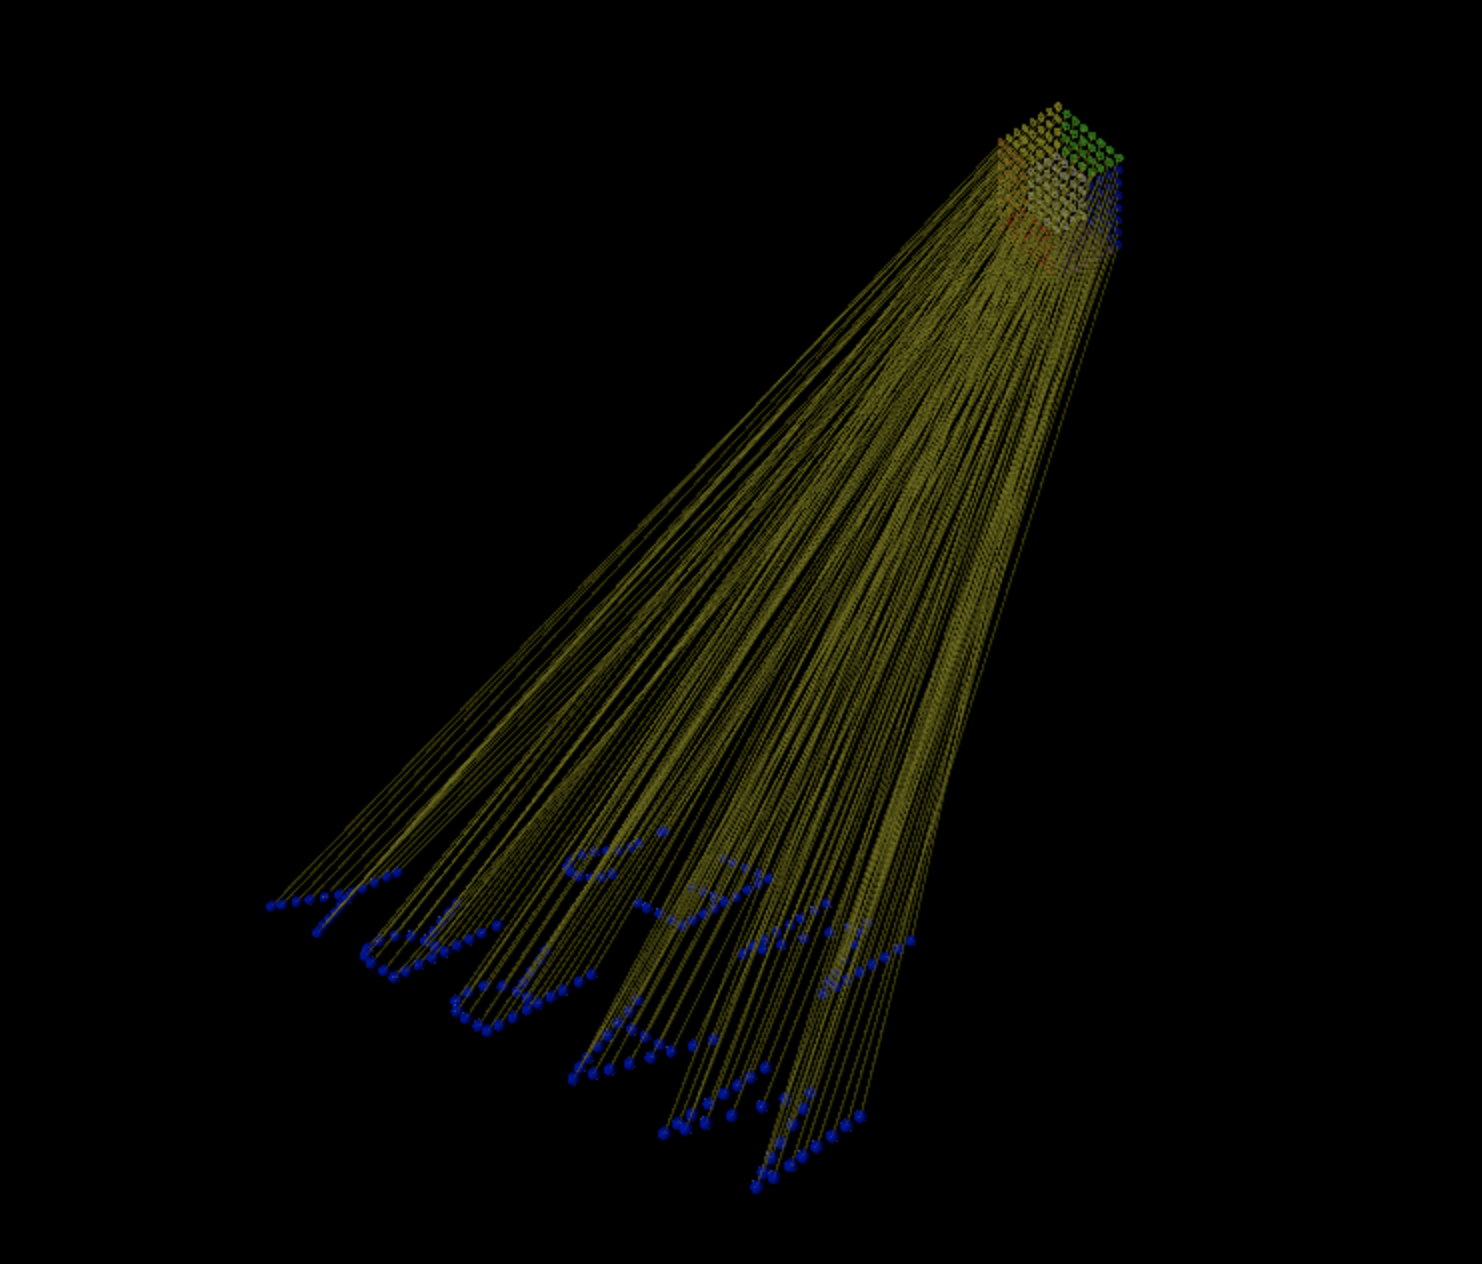

In [ ]:
# if scene:
#     scene.delete()
scene = vis.canvas(width=1200, height=1200)
vis.rate(10)

def vec_arrow(pos, axis, color=vis.color.yellow):
    return vis.cylinder(pos=pos, axis=axis, radius=2.0, color=color, opacity=0.2)

def np_to_vec(np_arr):
    return vec(*(np_arr))

def add_mirror_target(mirror_pos, mirror_normal, target_pos, mirror_color=vis.color.white):

    target = vis.sphere(pos = target_pos, radius = 10, color = vis.color.blue, opacity=0.5)
    mirror = vis.cylinder(pos = mirror_pos, radius = 10, axis = -0.5 * mirror_normal.norm(), color = mirror_color, opacity=0.5)

    v_target_mirror = mirror_pos - target_pos

#     arrow_target_pos = vec_arrow(pos=vec(0,0,0), axis=target_pos)
#     arrow_mirror_pos = vec_arrow(pos=vec(0,0,0), axis=mirror_pos)
    arrow_target_mirror = vec_arrow(pos=mirror_pos, axis=-1*v_target_mirror, color=vis.color.yellow)
#     arrow_mirror_sun = vec_arrow(pos=mirror_pos, axis=50 * v_mirror_sun, color=vis.color.red)


n_points = 999

# vis.sphere(pos = vec(0,-300,0), radius = 20, color = vis.color.white, opacity=0.5)
# vis.sphere(pos = vec(300,-300,0), radius = 20, color = vis.color.red, opacity=0.5)
# vis.sphere(pos = vec(0,300-300,0), radius = 20, color = vis.color.yellow, opacity=0.5)
# vis.sphere(pos = vec(0,-300,300), radius = 20, color = vis.color.green, opacity=0.5)

mirror_positions_sections = divide_hex_grid_flower(mirror_positions)
# sections_colors = [vis.color.white, vis.color.white, vis.color.white, vis.color.white, vis.color.white, vis.color.white, vis.color.white]
sections_colors = [vis.color.white, vis.color.red, vis.color.orange, vis.color.yellow, vis.color.green, vis.color.blue, vis.color.purple]

for i, (mirror_pos, mirror_normal, target_pos, section) in enumerate(zip(mirror_positions, mirror_normals, target_positions, mirror_positions_sections)):
    if i >= n_points:
        break
    add_mirror_target(np_to_vec(mirror_pos), np_to_vec(mirror_normal), np_to_vec(target_pos), mirror_color = sections_colors[int(section)])

In [ ]:
scene.delete()

# Printing the mirror array frame

So by this point I had developed the end-to-end process where you can input a set of coordinates that form your desired image, the location of the focal plane, and the location of the sun, and you get out a .stl model of the mirror array frame that you can 3D print. So now we just need to print this out and glue on the mirrors -- simple, right?

![](https://github.com/1kaiser/3D-printed-mirror-array/blob/main/img/yes_but_no.gif?raw=1)

I printed four different attempts at a smaller-scale mirror array to test for the big thing. Each small frame had 37 mirrors and would project the design of a heart. (37 mirrors corresponds to a radius $R=3$ hex grid, which was the largest I could print out in a single piece given my Ender3's 220mm × 220mm print area.)


![](https://github.com/1kaiser/3D-printed-mirror-array/blob/main/img/test_structures.jpg?raw=1)

There were two main problems I encountered when printing these test arrays. The first was warping due to the print not fully adhering to the print bed. This would cause the corners at the bottom to slightly peel up due to tension from the cooling layers, which would affect the angles of the hexagonal pillars above the warped base region and distort the projected image. I solved this problem by lowering the bed temperature and applying some hairspray to the print bed (some 3D printing tribal knowledge...), which worked like a charm.

The second problem was how to print out a hex grid which was too big to fit within the print volume. Some slicer programs include built in tools to slice large prints into pieces, but I couldn't use these because the planar cuts would slice through the hexagonal pillars, which would create a ridge on the top face and distort the angles of the mirrors, which need to be accurate to about $\delta \theta \approx \tan^{-1} \left(\frac{\text{pixel width}}{\text{focal length}}\right)$ (which is a few tenths of a degree). So I created a few custom functions to input a set of pillar models and partition them into smaller printable sub-volumes which could be glue together. This way, the only seams would be at the base of the model, which wouldn't affect the normal vectors of the mirrors.

I played around with a couple of different partitioning schemes, but I settled on using this flower-like pattern shown below, both because I liked the way it looked, and because it provides more structural strength since there is no continuous seam across the entire structure along which the assembled object could snap in half.


![](https://github.com/1kaiser/3D-printed-mirror-array/blob/main/img/hexflower.jpeg?raw=1)

The entire model took about a week to print (I used adaptive layer heights to speed things up a bit when printing the bottom and middle layers, but the top layers needed to be very fine to allow the mirrors to be mounted at exactly the right angles). I assembled the frame and used cyanoacrylate glue to bond each section of the frame at the base. (I had to slightly sand the edges of the final section to get it to fit.) The fully assembled frame is shown below.

![](https://github.com/1kaiser/3D-printed-mirror-array/blob/main/img/frames.jpeg?raw=1)

The last step was carefully glueing all 196 mirrors to the completed frame. I found out on some of my earlier test structures that cyanoacrylate glue will produce a lot of vapors when it is curing which can deposit on the mirrors and cause them to look foggy. (They still reflect enough light to work but it looks uglier...) To prevent this, I had a fan running blowing air from right to left while I glued the mirrors, which I attached in a right-to-left, top-to-bottom ordering to minimize vapor exposure.

![](https://github.com/1kaiser/3D-printed-mirror-array/blob/main/img/withmirrors.jpeg?raw=1)

By the time I finished mounting all of the mirrors, it was the night before I was planning to propose, so in a nail-biting twist of fate, I didn't actually get to test the final structure at sunset in advance. Fortunately, it worked exactly as I wanted it to! (And even more fortunately, the temperamental fog of the SF Bay Area decided to take the day off.)

This was the first project I've done with 3D printing (and in fact I got into 3D printing specifically to do this idea), and it felt like magic having a fabricator sitting in my bathroom that could just bring this idea into existence from nothing but a bit of code and some basic principles of physics.

![](https://github.com/1kaiser/3D-printed-mirror-array/blob/main/img/IMG_3009.jpeg?raw=1)
